<a href="https://colab.research.google.com/github/bkleck/WaterAnalytics/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importing Datasets and Libraries

In [7]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
cd /content/gdrive/MyDrive/Surface Water Hydrology

/content/gdrive/MyDrive/Surface Water Hydrology


In [25]:
import pandas as pd
from datetime import datetime, date 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
df = pd.read_csv('data/Aquifer_Petrignano_cleaned.csv', index_col=[0])
df.reset_index(drop=True, inplace=True)
df.head()

,date,rainfall,depth_p25,temp_umbra,volume,hydrometry,depth_diff_1,month,day_of_week,week_of_year,season,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos,season_sin,season_cos
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,0.00,1,3,1,1,0.5,0.866025,0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,0.03,1,4,1,1,0.5,0.866025,-0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,0.04,1,5,1,1,0.5,0.866025,-0.974928,-0.222521,0.120208,0.992749,1.0,6.123234e-17
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,0.02,1,6,1,1,0.5,0.866025,-0.781831,0.623490,0.120208,0.992749,1.0,6.123234e-17
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,0.04,1,0,2,1,0.5,0.866025,0.000000,1.000000,0.238673,0.971100,1.0,6.123234e-17


# 2) Univariate Time-Series Forecasting

We will be using 2 metrics to measure our model performance. 

1) **Mean Absolute Error (MAE)**: Measures the average magnitude of errors without considering the directions. It is the average of the absolute difference between predictions and actual observations.

2) **Root Mean Squared Error (RMSE)**: Also measures the average magnitude of errors. It is the square root of the average of squared differences between predictions and observations.

Both MAE and RMSE generally **represent the average error in predictions**, and **lower values** would mean less errors, hence **better model performance**. However, for **RMSE**, since the errors are squared, it gives a **high weight to large errors**, which is useful when large errors are undesirable.

## 2.1) ARIMA

Before we start using our ARIMA model, we have to do auto-correlation analysis to identify the terms required.

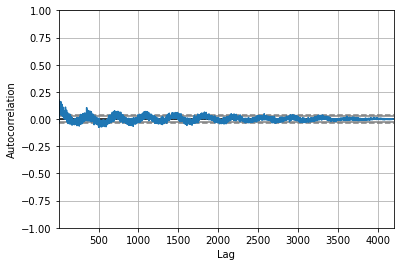

In [55]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_diff_1'])
plt.show()

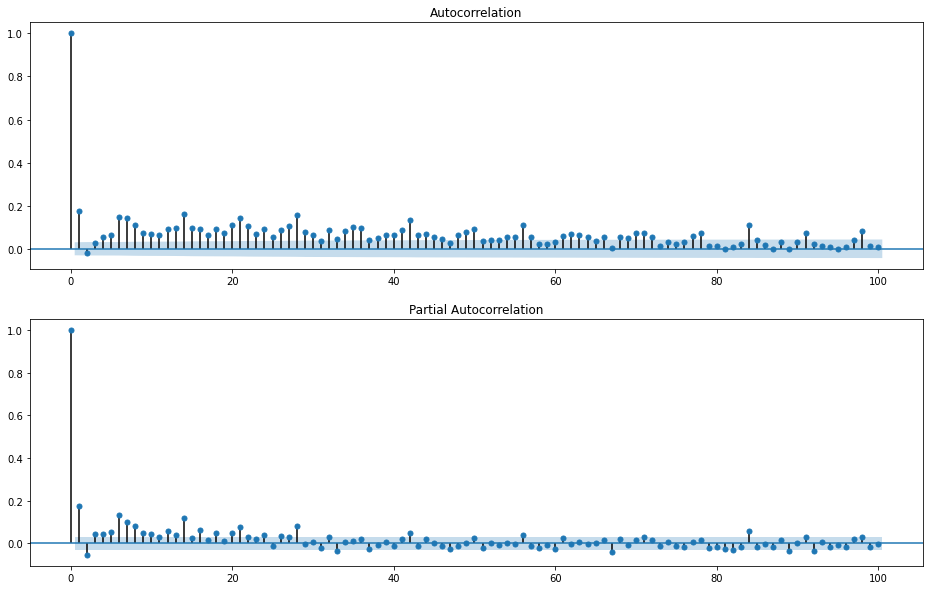

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

plot_acf(df['depth_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_diff_1'], lags=100, ax=ax[1])

plt.show()

Since 0 has the highest correlation for both the Autocorrelation (ACF) Plot and the Partial Autocorrelation (PACF) Plot, we have our terms for our ARIMA model.

- **ACF gives us P**, which is the number of periods to lag for.
- **PACF gives us D**, which is the number of differencing transformations required to make the time series stationary.

From the plots, we get **P=0 and D=0** since we have already made the necessary transformations and cleaning in our previous notebook to make it stationary.

For univariate analysis, we will only have 1 variable. We will **split our time series into training and validation set**.

We will start off by using our **non-stationary depth_p25** target variable. Hence, we will need to add terms to differentiate it.

In [72]:
train_size = int(0.75 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_p25']].copy()

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(x_valid)}')

Size of training set: 3149
Size of validation set: 1050


In [73]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(1050)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.1443906841122444


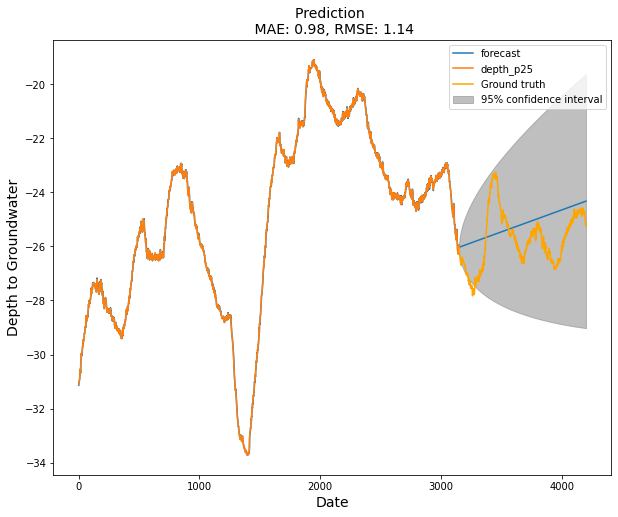

In [75]:
f, ax = plt.subplots(1, figsize=(10, 8))

model_fit.plot_predict(1, 4199, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['depth_p25'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

As seen from the results, the MAE and RMSE is still very high and the prediction is just a straight line, thus it is not very accurate. Now let us try with the **differentiated depth_diff_1** target variable. Since it is already differentiated, we do not need to add terms.

In [76]:
train_size = int(0.75 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_diff_1']].copy()

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(x_valid)}')

Size of training set: 3149
Size of validation set: 1050


In [77]:
# Fit model
model = ARIMA(y_train, order=(0,0,0))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(1050)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 0.06635018473767014


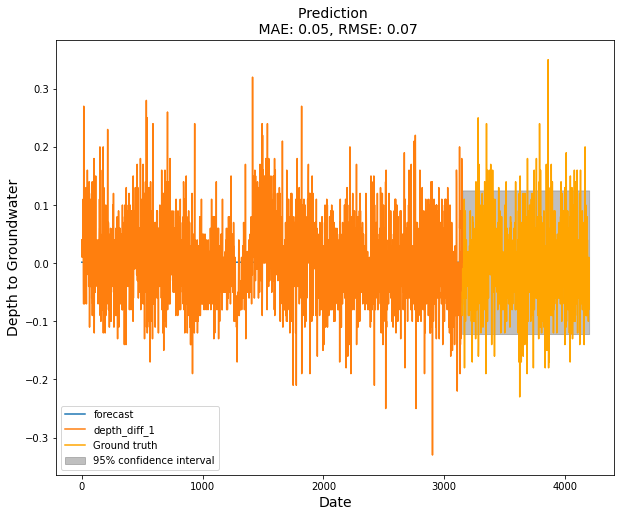

In [78]:
f, ax = plt.subplots(1, figsize=(10, 8))

model_fit.plot_predict(1, 4199, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['depth_diff_1'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

The model performed **much better with the differenced depth variable**. However, from the plot, we can see that the forecast is very similar to the ground truth, hence the model might have **overfitted** to the training set.